In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff, Optim
using SpecialFunctions
using BenchmarkTools
using  MAT, DSP, FFTW, WAV
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



┌ Warning: Error requiring `Optimisers` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/PhD/ReactiveMP.jl/ext/ReactiveMPOptimisersExt/ReactiveMPOptimisersExt.jl", 1, ArgumentError("Package ReactiveMP does not have Optimisers in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Optimisers as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000002b9b7866f, Ptr{Nothing} @0x00000002b9b7883b, Ptr{Nothing} @0x000000010272d2a3, Ptr{Nothing} @0x000000010276290b, Ptr{Nothing} @0x0000000102761717, Ptr{Nothing} @0x0000000102761a93, Ptr{Nothing} @0x0000000102762073, Ptr{Nothing} @0x0000000102762e07, Ptr{Nothing} @0x0000000119117

┌ Warning: Error requiring `Zygote` from `ReactiveMP`
│   exception = (LoadError("/Users/nguyenhuuminhhoang/PhD/ReactiveMP.jl/ext/ReactiveMPZygoteExt/ReactiveMPZygoteExt.jl", 1, ArgumentError("Package ReactiveMP does not have Zygote in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have ReactiveMP checked out for development and have\n  added Zygote as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with ReactiveMP")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000002b9b7866f, Ptr{Nothing} @0x00000002b9b7883b, Ptr{Nothing} @0x000000010272d2a3, Ptr{Nothing} @0x000000010276290b, Ptr{Nothing} @0x0000000102761717, Ptr{Nothing} @0x0000000102761a93, Ptr{Nothing} @0x0000000102762073, Ptr{Nothing} @0x0000000102762e07, Ptr{Nothing} @0x0000000119117ed7, Ptr{Nothing} @0

In [3]:
function generate_cleandata(n, f_gp, c_gp)
    y=Float64[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
    end
    return y
end

generate_cleandata (generic function with 1 method)

## Create synthetic data
The signal is made of two components: $y_t = 0.7 * y_t^{(1)} + 0.3 * y_t^{(2)}$, where the superscript denotes the class label. Each component is created in a similar way as we did for single case.

In [4]:
N = 500; #data length
n = 500; #lenght of the axis of gp 

#class 1
θcarrier   = 0.01
θamplitude = 1.
mean_amplitude = (x) -> 0;
mean_carrier   = (x) -> 0.;
kernel_carrier(θ)     =  0.5with_lengthscale(Matern52Kernel(),θ)
kernel_amplitude(θ)   =  with_lengthscale(Matern52Kernel(),θ) #+ with_lengthscale(PeriodicKernel(),3.0)
tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=n));
Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),time_range,time_range) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),time_range,time_range) + 1e-7I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_gt = rand(StableRNG(1133),gp_amplitude)
carrier_gt   = rand(StableRNG(11), gp_carrier)

#class 2
kernel_carrier_2(θ)     =  0.1with_lengthscale(Matern52Kernel(),θ)
kernel_amplitude_2(θ)   =  0.8with_lengthscale(Matern52Kernel(),θ)

θcarrier_2   = 0.001
θamplitude_2 = .5
Cov_amplitude_2 = kernelmatrix(kernel_amplitude(θamplitude_2),time_range,time_range) + 1e-7*I;
Cov_carrier_2   = kernelmatrix(kernel_carrier(θcarrier_2),time_range,time_range) + 1e-7I;
gp_amplitude_2  = MvNormal(mean_amplitude.(time_range), Cov_amplitude_2)
gp_carrier_2    = MvNormal(mean_carrier.(time_range), Cov_carrier_2)
amplitude_gt_2 = rand(StableRNG(13),gp_amplitude_2)
carrier_gt_2   = rand(StableRNG(1321), gp_carrier_2)

#Generate data 
y_data_synthetic = 0.7*generate_cleandata(n,amplitude_gt,carrier_gt) + 0.3*generate_cleandata(n,amplitude_gt_2,carrier_gt_2);
slicedim(dim) = (a) -> map(e -> e[dim], a);

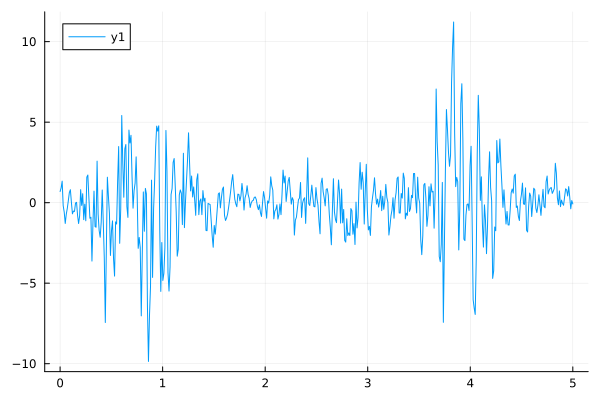

In [5]:
plot(time_range, y_data_synthetic)


In [6]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    if isnothing(messages[1].addons)
        @logscale 0.
    else
        @logscale getlogscale(messages[1])
    end
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    scalefactor = (x) -> exp(l_pdf(x))/exp(-x^2)
    x, w = ReactiveMP.gausshermite(9)
    Z = dot(w,scalefactor.(x)) #we use GaussHermite to approximate the scale factor
    if isnothing(messages[1].addons)
        @logscale log(z)
    else
        @logscale log(Z) + getlogscale(messages[1]) #correct 
    end

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v+1e-6)
    end
end

@marginalrule MyExponential(:x) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    b_x = @call_rule MyExponential(:x, Marginalisation) (m_y = m_y, m_x=m_x)
    q_x = ReactiveMP.prod(ProdAnalytical(),b_x,m_x)
    if isinf(entropy(m_x)) || isnan(entropy(m_x))
        q_x= m_x 
    end
    return (x=m_x)
end

In [7]:
@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    nsamples = 3000
    samples = rand(StableRNG(1),m_in,nsamples)
    Z = sum(1 ./ abs.(samples)) / nsamples
    if isnothing(messages[3].addons)
        @logscale log(Z)
    else
        @logscale log(Z) + getlogscale(messages[3])#correct 
    end

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v+1e-6)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    
    scalefactor = (x) -> exp(backward_A(x))/exp(-x^2)
    points, w = ReactiveMP.gausshermite(9)
    Z = dot(w,scalefactor.(points))
    if isnothing(messages[2].addons)
        @logscale log(Z)
    else
        @logscale log(Z) + getlogscale(messages[2])#correct 
    end
    return ContinuousUnivariateLogPdf(backward_A)
end

# @marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::NormalMeanVariance, m_in::LogNormal, meta::TinyCorrection) = begin 
#     b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
#     q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)
#     if isinf(entropy(q_A))
#         q_A = m_A
#     end
#     return (A = q_A,in = m_in, out=m_out)
# end

In [8]:
@model function MixturePAD(n,nmixtures, P_amp,A_amp,Q_amp,P_carr,A_carr,Q_carr,H)
    y = datavar(Float64,n)

    yk = randomvar(nmixtures,n)
    fk_0 = randomvar(nmixtures)
    ck_0 = randomvar(nmixtures)
    fk = randomvar(nmixtures,n)
    ck = randomvar(nmixtures,n)

    zk = randomvar(nmixtures,n)
    gk = randomvar(nmixtures,n)
    dk = randomvar(nmixtures,n)

    s = randomvar(n)


    for k=1:nmixtures
        fk_0[k] ~ MvNormalMeanCovariance(zeros(length(H)), P_amp[k])
        ck_0[k] ~ MvNormalMeanCovariance(zeros(length(H)), P_carr[k])
        f_prev = fk_0[k]
        c_prev = ck_0[k]
        for j=1:n
            fk[k,j] ~ MvNormalMeanCovariance(A_amp[k][j] * f_prev, Q_amp[k][j])
            zk[k,j] ~ NormalMeanVariance(dot(H , fk[k,j]), .1)
            gk[k,j] ~ MyExponential(zk[k,j]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 1.))}

            ck[k,j] ~ MvNormalMeanCovariance(A_carr[k][j] * c_prev, Q_carr[k][j])
            dk[k,j] ~ NormalMeanVariance(dot(H,ck[k,j]), .1) 

            yk[k,j] ~ (*)(dk[k,j],gk[k,j]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 1.))}
            f_prev = fk[k,j]
            c_prev = ck[k,j]
        end 
    end
    
    y_tup = tuple(yk...)
    π ~ Dirichlet(ones(nmixtures))

    for i=1:n 
        s[i] ~ Categorical(π) where { pipeline = EnforceMarginalFunctionalDependency(:out) }
        y[i] ~ Mixture(s[i], y_tup[(i-1)*nmixtures+1:i*nmixtures]) where { pipeline = EnforceMarginalFunctionalDependency(:switch) }
    end
end

In [9]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######

Δt_synthetic = [time_range[2] - time_range[1]]; # time difference
append!(Δt_synthetic, time_range[2:end] - time_range[1:end-1]);

L = [0., 0., 1.];
H = [1., 0., 0.];
function compute_F(θ)
    λ = sqrt(5)/θ[1]
    return [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
end
function compute_P(θ)
    Qc = 16/3 * θ[2] * (sqrt(5)/θ[1])^5;
    F = compute_F(θ)
    Imat = diageye(3)
    P_vec = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L')
    return reshape(P_vec,3,3);
end
function compute_A(θ,Δt)
    F = compute_F(θ)
    A = [exp(F * i) for i in Δt];
    return A #an array of matrices A 
end

function compute_Q(θ,Δt)
    A = compute_A(θ,Δt)
    P = compute_P(θ)

    Q = [P - i*P*i' for i in A]
    return Q #an array of matrices Q 
end

compute_Q (generic function with 1 method)

In [10]:
#Bart's code for mixture node 
@rule Categorical(:p, Marginalisation) (m_out::Categorical,q_out::PointMass,) = begin
    @logscale -SpecialFunctions.logfactorial(length(probvec(q_out))) + getlogscale(messages[1])
    return Dirichlet(probvec(q_out) .+ one(eltype(probvec(q_out))))
end

struct EnforceMarginalFunctionalDependency <: ReactiveMP.AbstractNodeFunctionalDependenciesPipeline
    edge :: Symbol
end

function ReactiveMP.message_dependencies(::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    return ReactiveMP.message_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
end

function ReactiveMP.marginal_dependencies(enforce::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    default = ReactiveMP.marginal_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    index   = ReactiveMP.findnext(i -> name(i) === enforce.edge, nodeinterfaces, 1)
    if index === iindex 
        return default
    end
    vmarginal = ReactiveMP.getmarginal(ReactiveMP.connectedvar(nodeinterfaces[index]), IncludeAll())
    loc = ReactiveMP.FactorNodeLocalMarginal(-1, index, enforce.edge)
    ReactiveMP.setstream!(loc, vmarginal)
    # Find insertion position (probably might be implemented more efficiently)
    insertafter = sum(first(el) < iindex ? 1 : 0 for el in default; init = 0)
    return ReactiveMP.TupleTools.insertafter(default, insertafter, (loc, ))
end

# function for using hard switching
function ReactiveMP.functional_dependencies(::EnforceMarginalFunctionalDependency, factornode::MixtureNode{N, F}, iindex::Int) where {N, F <: FullFactorisation}
    message_dependencies = if iindex === 1
        # output depends on:
        (factornode.inputs,)
    elseif iindex === 2
        # switch depends on:
        (factornode.out, factornode.inputs)
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.out, )
    else
        error("Bad index in functional_dependencies for SwitchNode")
    end

    marginal_dependencies = if iindex === 1
        # output depends on:
        (factornode.switch,)
    elseif iindex == 2
        #  switch depends on
        ()
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.switch,)
    else
        error("Bad index in function_dependencies for SwitchNode")
    end
    # println(marginal_dependencies)
    return message_dependencies, marginal_dependencies
end

# create an observable that is used to compute the switch with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface, NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface  = messages[1]
    inputsinterfaces = messages[2]

    msgs_names = Val{(name(switchinterface), name(inputsinterfaces[1]))}()
    msgs_observable =
    combineLatest((ReactiveMP.messagein(switchinterface), combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew())), PushNew()) |>
        map_to((ReactiveMP.messagein(switchinterface), ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces))))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the output with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    inputsinterfaces = messages[1]

    msgs_names = Val{(name(inputsinterfaces[1]), )}()
    msgs_observable =
    combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew()) |>
        map_to((ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces)),))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the input with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    outputinterface = messages[1]

    msgs_names = Val{(name(outputinterface), )}()
    msgs_observable = combineLatestUpdates((ReactiveMP.messagein(outputinterface), ), PushNew())
    return msgs_names, msgs_observable
end

function ReactiveMP.get_marginals_observable(factornode::MixtureNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, marginals::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface = marginals[1]

    marginal_names       = Val{(name(switchinterface), )}()
    marginals_observable = combineLatestUpdates((getmarginal(ReactiveMP.connectedvar(switchinterface), IncludeAll()), ), PushNew())
    return marginal_names, marginals_observable
end


In [11]:
@constraints function constraints_MixturePAD()
    q(s) :: PointMass
end;

In [12]:
#Here let's say we don't know how many components there are in the signal, so we assume there are 3 classes. We hope that after running inference the irrelevant component (the third one) will have the least contribution to the signal. 
nmixtures = 3
θ_amplitude = [[0.5,0.8],[1., 1.],[5., 4.]
    ]; # store [l, σ²]

θ_carrier = [[0.001,0.1],[0.01, .5],[2.,1.5]
]; # store [l, σ²]

#([5.,4.] [2.,1.5]) is the irrelevant component 

3-element Vector{Vector{Float64}}:
 [0.001, 0.1]
 [0.01, 0.5]
 [2.0, 1.5]

In [13]:
A_amplitude_tensor = [compute_A(i,Δt_synthetic) for i in θ_amplitude]
Q_amplitude_tensor = [compute_Q(i,Δt_synthetic) for i in θ_amplitude]
P_amplitude_tensor = [compute_P(i) for i in θ_amplitude]

A_carrier_tensor = [compute_A(i,Δt_synthetic) for i in θ_carrier]
Q_carrier_tensor = [compute_Q(i,Δt_synthetic) for i in θ_carrier]
P_carrier_tensor = [compute_P(i) for i in θ_carrier]

3-element Vector{Matrix{Float64}}:
 [0.1000000000000002 -2.69275347221207e-13 -166666.6666666669; 8.801016418635455e-14 166666.6666666669 -6.106687794882766e-8; -166666.66666666706 6.106687794882766e-8 2.500000000000001e12]
 [0.4999999999999979 8.253050944653583e-14 -8333.333333333336; 5.226915617886441e-14 8333.333333333336 -1.3170641551236749e-9; -8333.333333333332 1.3170641551236749e-9 1.25e9]
 [1.4999999999999993 4.892197842346172e-16 -0.6250000000000001; 2.8657213865515575e-16 0.6249999999999989 5.304015957938132e-16; -0.624999999999999 -1.4250563434892666e-16 2.34375]

In [14]:
niters = 5

result = inference(
    model = MixturePAD(N,nmixtures,P_amplitude_tensor,A_amplitude_tensor,Q_amplitude_tensor,P_carrier_tensor,A_carrier_tensor,Q_carrier_tensor,H),
    iterations = niters,
    data = (y=y_data_synthetic,),
    initmessages = (π = Dirichlet(ones(nmixtures)),),
    returnvars = (π = KeepLast(),fk = KeepLast(),ck = KeepLast(),),
    constraints = constraints_MixturePAD(),
    addons = AddonLogScale(),
    options = (limit_stack_depth=100,),
    showprogress = true,
)

Progress:  40%|████████████████▍                        |  ETA: 0:00:31

Progress:  60%|████████████████████████▋                |  ETA: 0:00:16

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


Inference results:
  Posteriors       | available for (π, ck, fk)


In [15]:
π_pos = mean(result.posteriors[:π])

3-element Vector{Float64}:
 0.0019880715705765406
 0.0019880715705765406
 0.9960238568588469

In [16]:
fk_posterior = [result.posteriors[:fk][i,:] for i=1:nmixtures];
ck_posterior = [result.posteriors[:ck][i,:] for i=1:nmixtures];

In [17]:
mgp1 = mean.(fk_posterior[1]) |> slicedim(1)
expmgp1 = exp.(mgp1);

mgp2 = mean.(fk_posterior[2]) |> slicedim(1)
expmgp2 = exp.(mgp2);

mgp3 = mean.(fk_posterior[3]) |> slicedim(1)
expmgp3 = exp.(mgp3);

PAD_carrier_synthetic1 = mean.(ck_posterior[1]) |> slicedim(1)
PAD_carrier_synthetic2 = mean.(ck_posterior[2]) |> slicedim(1)
PAD_carrier_synthetic3 = mean.(ck_posterior[3]) |> slicedim(1)
;

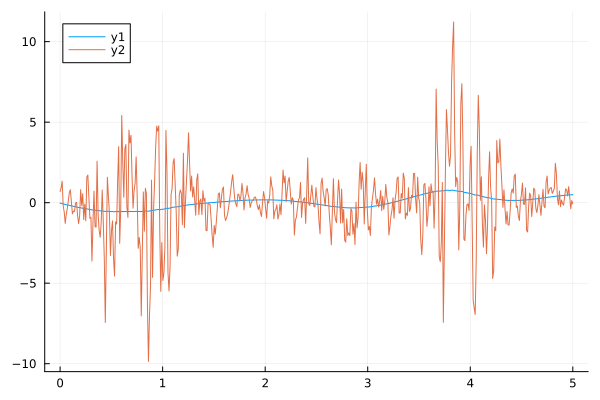

In [18]:
y_pos = π_pos[1]*(expmgp1 .* PAD_carrier_synthetic1)  + π_pos[2]*(expmgp2 .* PAD_carrier_synthetic2) +  π_pos[3] * (expmgp3 .* PAD_carrier_synthetic3);
plot(time_range,y_pos)
plot!(time_range,y_data_synthetic)